# Outlier Idenfication algorithm
This file create 2 new features for each transaction:
1. Natural_var: This is a boolean attribute, indicating if a transaction's respective merchant sells more than one type of item ($157) 
2. Potential_outlier: This determines if a transactions dollar_value is outside the 'normal' distribution

Please Note: Transactios with dollar_values under $1 have not been removed

In [1]:
# Open Spark session 
from pyspark.sql import SparkSession, functions as F


# Create a spark session (which will run spark jobs)
spark = (
    SparkSession.builder.appName("Data_Explorer")
    .config("spark.sql.repl.eagerEval.enabled", True) 
    .config("spark.sql.parquet.cacheMetadata", "true")
    .config("spark.driver.memory", "6g")
    .config("spark.sql.execution.arrow.pyspark.enabled", "true")
    .getOrCreate()
)

22/10/02 18:01:31 WARN Utils: Your hostname, James-N580VD-DM229T resolves to a loopback address: 127.0.1.1; using 172.22.102.151 instead (on interface eth0)
22/10/02 18:01:32 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address


Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).


22/10/02 18:01:33 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [2]:
# Read the files 
transactions_sample = spark.read.parquet('../data/tables/transactions_20210828_20220227_snapshot')
transactions_sample2 = spark.read.parquet('../data/tables/transactions_20210228_20210827_snapshot')
transactions_sample3 = spark.read.parquet('../data/tables/transactions_20220228_20220828_snapshot')
transactions_sample.unionByName(transactions_sample2, True)
transactions_sample.unionByName(transactions_sample3, True)
consumer_details = spark.read.parquet('../data/tables/consumer_user_details.parquet')
merchants_tbl = spark.read.parquet('../data/tables/tbl_merchants.parquet')
customer_tbl = spark.read.option("delimiter", "|").option("header",True).csv('../data/tables/tbl_consumer.csv')

In [3]:
merchants = merchants_tbl.toPandas()

In [4]:
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
#nltk.download('stopwords')
#nltk.download('wordnet')
#nltk.download('omw-1.4')
import string
import re

# This is used to for NLP of the description
def text_process(text):
    stemmer = WordNetLemmatizer()
    # Remove all punctuation and numbers 
    nopunc = [char for char in text if char not in string.punctuation]
    nopunc = ''.join([i for i in nopunc if not i.isdigit()])
    # Remove all stopwords
    nopunc =  [word.lower() for word in nopunc.split() if word not in stopwords.words('english')]
    # lemmatize and output
    return ' '.join([stemmer.lemmatize(word) for word in nopunc])

In [5]:
# this function standardises the tags attribute, creating a list with the 'description', 'revenue band' and 'BNPL service charge'
def tag_extract(tag_string): 
    # first need to preprocess
    string =  re.sub('\[','(', tag_string.lower())
    string = re.sub('\]',')', string)
    # break the string into sections
    string_cut = string.split('),')
    new_string = []
    # first extract the description and pre process
    descr = str(string_cut[0].strip('(('))
    #descr = re.sub(r'[-|,|_|:]', ' ', descr)
    #descr = re.sub(r' +', ' ', descr)
    #descr = descr.split()
    #descr = ' '.join([word for word in descr if word not in stop_words])
    new_string.append(text_process(descr))
    # second extract the band
    new_string.append(str(re.search(r'[a-z]',string_cut[1]).group()))
    # finally the take rate
    new_string.append(float(re.search(r'[0-9]+\.[0-9]+',string_cut[2]).group()))
    return(new_string)
################
# now we can run the algorithm
tags = merchants['tags']
processed_tags = []
for i in tags:
    processed_tags.append(tag_extract(i))

In [6]:
import pandas as pd
merchant_tbl = pd.DataFrame(processed_tags, columns=('Description', 'Earnings_Class', 'BNPL_Fee'))
merchant_tbl = pd.concat([merchants, merchant_tbl], axis=1)
# drop the tags column 
merchant_tbl.drop(columns='tags', inplace=True)

In [7]:
# and convert back to spark dataframe 
merchants_tbl = spark.createDataFrame(merchant_tbl)

In [8]:
# This could be further expanded in breaking the discription up further

In [9]:
customer_tbl = customer_tbl.join(consumer_details, ['consumer_id'])

In [10]:
full_dataset = transactions_sample.join(customer_tbl, ['user_id'])
merchants_tbl = merchants_tbl.withColumnRenamed('name','company_name')
full_dataset = full_dataset.join(merchants_tbl, ['merchant_abn'])

In [11]:
# lets add a day (mon,...), weekly & monthly attribute
import pyspark.sql.functions as F
full_dataset = full_dataset.withColumn('Day', F.dayofweek('order_datetime'))
full_dataset = full_dataset.withColumn('Month', F.month('order_datetime'))
# now we can round each dollar value to the nearest cent (not 5 cents, as there exists unusual pricing in the real world)
full_dataset = full_dataset.withColumn("dollar_value", F.round(F.col("dollar_value"), 2))
# now we can also add the bnpl revenue from a transaction 
full_dataset = full_dataset.withColumn('BNPL_Revenue', F.col('dollar_value') * 0.01 * F.col('BNPL_Fee'))
full_dataset.createOrReplaceTempView('data')
# we can remove name, location and customerID for now, due to being unnnesesary attributes (although company_name could also be removed)
full_dataset = spark.sql("""
select merchant_abn, user_id, dollar_value, order_id, order_datetime, state, postcode, gender, company_name, 
        Description, Earnings_Class, BNPL_Fee, BNPL_Revenue, Day, Month, weekofyear(order_datetime) as weekofyear from data
""")

# Outlier detection algorithm
This will be inplemented by creating an attribute called 'potential outlier'. which marks dollar values of transactios that fall out of a companies specific SIQR as True, and False otherwise. Furthermore, it marks all transactions that belong to a company, which has no variance in the dollar value of respective transactios. This is due to it being unrealistic/dodgy.

In [12]:
# use the SIQR range
# see https://towardsdatascience.com/outlier-detection-part-2-6839f6199768
Fst_percentile = F.expr('percentile_approx(dollar_value, 0.25)')
Trd_percentile = F.expr('percentile_approx(dollar_value, 0.75)')
Second_percentile = F.expr('percentile_approx(dollar_value, 0.5)')
quartile_dataset = full_dataset.groupBy('merchant_abn').agg(Fst_percentile.alias('1_val'), Trd_percentile.alias('3_val'), Second_percentile.alias('2_val'), F.count('dollar_value').alias('Count'))
quartile_dataset = quartile_dataset.withColumn('SIQR_Lower', F.col('2_val') - F.col('1_val'))
quartile_dataset = quartile_dataset.withColumn('SIQR_Upper', F.col('3_val') - F.col('2_val'))
# Now calculate the limits
quartile_dataset = quartile_dataset.withColumn('Upper_limit', F.col('3_val') + 3 * F.col('SIQR_Upper'))
quartile_dataset = quartile_dataset.withColumn('Lower_limit', F.col('1_val') - 3 * F.col('SIQR_Lower'))
# after noticing that some merchants only have one transaction value (i.e one dollar_value amount for all transactios)
# decided to removed due to unrealisic distributed data 
quartile_dataset = quartile_dataset.withColumn('Natural_var', F.when((F.col('Upper_limit') == F.col('Lower_limit')) & (F.col('Count') > 10), True).otherwise(False))
quartile_dataset = quartile_dataset.select('merchant_abn', 'Upper_limit', 'Lower_limit', 'Natural_var')

In [13]:
# Now all we need to do is join this data to each transaction, then can select the transactios which are (not) within the limits
full_quantile = full_dataset.select('merchant_abn', 'order_id', 'user_id', 'dollar_value').join(quartile_dataset, on= ['merchant_abn'])

In [14]:
# finally identify the outliers which fall out of distribution or apart of a dodgy business
full_quantile = full_quantile.withColumn('Potential_Outlier', F.when((full_quantile.dollar_value <= F.col('Upper_limit')) & (full_quantile.dollar_value >= F.col('Lower_limit')) & (F.col('Natural_var') == False), False)
                                              .otherwise(True))

In [15]:
full_quantile.where(F.col('Potential_Outlier') == True).count()

108542

<AxesSubplot:xlabel='dollar_value', ylabel='Count'>

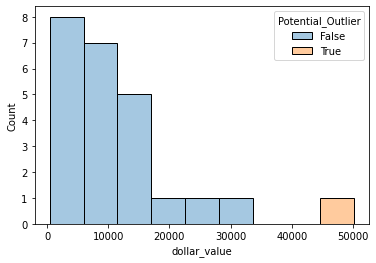

In [16]:
import seaborn as sns
sns.histplot(x='dollar_value', hue = 'Potential_Outlier',alpha = 0.4, data=full_quantile.where(full_quantile.merchant_abn == 35575706403).select('dollar_value', 'Potential_Outlier').toPandas())

# Description Tag analysis
There are a total of 26 unique tags, so lets look further into detail of differences between them

In [17]:
# First lets join the new attributes obtained above to the transaction spark dataframe
full_quantile = full_quantile.select(['order_id', 'Natural_var', 'Potential_Outlier'])
full_dataset = full_dataset.join(full_quantile, on='order_id')

In [18]:
# Remove transactions below $1
main_agg = full_dataset.where(full_dataset.dollar_value >= 1.0).groupBy('Description').agg(
    F.count('order_id').alias('Count'),
    F.count_distinct('merchant_abn').alias('Merchant_Number'),
    F.avg('dollar_value').alias('Dollar_AVG'),
    F.avg('BNPL_Fee').alias('BNPL_Fee'),
    F.avg('BNPL_Revenue').alias('BNPL_Revenue_AVG'),
    F.min('dollar_value').alias('Dollar_MIN'),
    F.max('dollar_value').alias('Dollar_MAX')
)

Outlier_agg1 = full_dataset.where(full_dataset.Potential_Outlier==True).groupBy('Description').agg(F.count('Potential_Outlier').alias('Potential_count'))
Outlier_agg2 = full_dataset.where(full_dataset.Natural_var==True).groupBy('Description').agg(F.count('Natural_var').alias('Nat_var_count'))
main_agg = main_agg.join(Outlier_agg1,  on='Description', how='left')
main_agg = main_agg.join(Outlier_agg2, on='Description', how='left')
main_agg = main_agg.withColumn('Potential_count', F.col('Potential_count') / F.col('Count'))
main_agg = main_agg.withColumn('Nat_var_count', F.col('Nat_var_count') / F.col('Count'))
main_agg = main_agg.withColumn('Tran_per_Merch_AVG', F.col('Count') / F.col('Merchant_Number'))

# merchant_abn, user_id, dollar_value, order_id, order_datetime, state, postcode, gender, company_name, 
#        Description, Earnings_Class, BNPL_Fee, BNPL_Revenue, Day, Month, weekofyear(order_datetime) as weekofyear from data

In [19]:
main_bb = main_agg.toPandas()

In [20]:
b = set(main_bb['Description'])
b.remove('health beauty spa')
b

{'antique shop sale repair restoration service',
 'art dealer gallery',
 'artist supply craft shop',
 'bicycle shop sale service',
 'book periodical newspaper',
 'cable satellite pay television radio service',
 'computer computer peripheral equipment software',
 'computer programming data processing integrated system design service',
 'digital good book movie music',
 'equipment tool furniture appliance rent al leasing',
 'florist supply nursery stock flower',
 'furniture home furnishing equipment shop manufacturer except appliance',
 'gift card novelty souvenir shop',
 'hobby toy game shop',
 'jewelry watch clock silverware shop',
 'lawn garden supply outlet including nursery',
 'motor vehicle supply new part',
 'music shop musical instrument piano sheet music',
 'optician optical good eyeglass',
 'shoe shop',
 'stationery office supply printing writing paper',
 'telecom',
 'tent awning shop',
 'watch clock jewelry repair shop'}

In [27]:
main_bb.sort_values(by=['BNPL_Revenue_AVG'])

,Description,Count,Merchant_Number,Dollar_AVG,BNPL_Fee,BNPL_Revenue_AVG,Dollar_MIN,Dollar_MAX,Potential_count,Nat_var_count,Tran_per_Merch_AVG
16,digital good book movie music,405183,195,64.715430,4.902602,3.256789,1.00,697.71,0.022805,NaN,2077.861538
5,gift card novelty souvenir shop,515759,182,68.640962,4.731716,3.315935,1.00,676.66,0.021997,NaN,2833.840659
22,watch clock jewelry repair shop,325250,170,73.560486,5.163516,3.651234,1.00,872.00,0.021802,NaN,1913.235294
10,tent awning shop,566554,178,82.455005,4.712820,3.890223,1.00,6692.21,0.017573,NaN,3182.887640
20,cable satellite pay television radio service,302583,175,79.148523,4.903758,3.902845,1.00,625.63,0.065033,0.042048,1729.045714
15,optician optical good eyeglass,262938,151,89.716427,4.012606,3.952073,1.00,1698.85,0.028349,NaN,1741.311258
24,florist supply nursery stock flower,279161,180,116.799947,4.047983,5.133508,1.00,2294.78,0.022371,NaN,1550.894444
19,computer computer peripheral equipment software,226707,181,168.367114,4.213390,7.295239,1.00,2820.86,0.022628,NaN,1252.524862
18,computer programming data processing integrate...,164075,191,191.867721,4.437380,8.652318,1.00,9329.82,0.023386,NaN,859.031414
6,shoe shop,136528,185,200.493366,4.495308,8.939079,1.00,2335.70,0.023702,NaN,737.989189


# Plotting of merchants by description 


In [22]:
#subset = full_dataset.where(full_dataset.Description is in ('digital good book movie music', 'gift card novelty souvenir shop'))
subset = full_dataset.sample(withReplacement=False, fraction=0.05).toPandas()

In [23]:
subset_2 = subset[(subset['Natural_var'] == False) & (subset['Potential_Outlier'] == False)]

In [24]:
subset.groupby('Description').dollar_value.max()

Description
antique shop sale repair restoration service                              35929.34
art dealer gallery                                                        23152.92
artist supply craft shop                                                   3442.30
bicycle shop sale service                                                  5482.14
book periodical newspaper                                                  1683.62
cable satellite pay television radio service                                545.00
computer computer peripheral equipment software                            2090.61
computer programming data processing integrated system design service      4581.40
digital good book movie music                                               475.67
equipment tool furniture appliance rent al leasing                        10956.94
florist supply nursery stock flower                                        1748.70
furniture home furnishing equipment shop manufacturer except appliance     

<AxesSubplot:xlabel='Description', ylabel='BNPL_Revenue'>

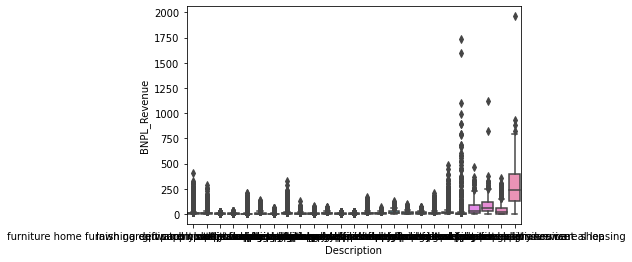

In [25]:
sns.boxplot(x='Description', y= 'BNPL_Revenue', data = subset_2)

<AxesSubplot:xlabel='Description', ylabel='BNPL_Revenue'>

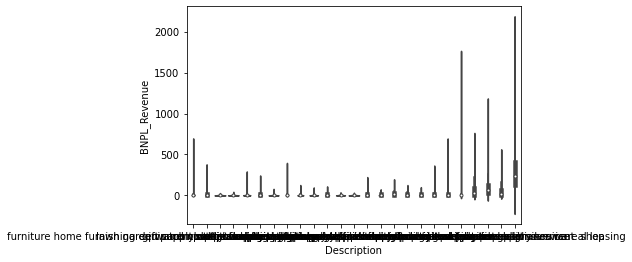

In [26]:
sns.violinplot(x='Description', y= 'BNPL_Revenue', data = subset)